In [4]:
import bt
import pandas as pd
import seaborn as sns
import datetime
import dask.dataframe as dd

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Downloading Historical data
First let's download some historical data from Poloniex. With this API you can only fetch one year at a time.

In [22]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
pairs = ['USDT_BTC','USDT_ETH', 'USDT_LTC']

def get_full_table(pair, start, end):
    """
    gets 300000 raw trades
    """
    df = pd.read_json('https://poloniex.com/public?command=returnTradeHistory&currencyPair={}&start={}&end={}'.format(pair, int(start.timestamp()), int(end.timestamp())))
    df.set_index(['date'], inplace=True)
    print('fetched {} {} trades.'.format(df.size,pair))
    return df

def get_price_table(pair, start, end):
    """
    Poloniex API only returns maximum of 300000 trades or 1 year for each pair.
    :returns:
    dictionary with one dataframe per pair
    """
    print('Downloading {} from {} to {}.'.format(pair,start,end))
    
    df = get_full_table(pair,start,end)
    
    df = df.resample('1T').mean() #resample in windows of 1 minute
    df[pair] = df.rate
    for cname in df.columns:
        if cname not in pairs:
            del df[cname]

    return df

def concatenate_series(rates):
    """
    :parameters:
    - rates: dictionary with the pairs dataframes
    """
    for k, df in rates.items(): #Solve non-unique indices
        rates[k] = df.loc[~df.index.duplicated(keep='first')]
    data = pd.concat(rates, axis=1)
    data.columns = data.columns.droplevel(0)
    print(data.columns)
    data.columns = [name.lower() for name in data.columns] #convenient to save to PGSQL
    return data

def extend_history(pair, df):
    End = df.index.min()
    Start = end - datetime.timedelta(days=364)
    dfextra = get_price_table(pair,Start,End)
    df = df.append(dfextra)#pd.concat([df,dfextra], axis=0)
    return df

### Downloading the data

In [23]:
rates = {pair: get_price_table(pair, start, end) for pair in pairs}

fetched 300000 USDT_BTC trades.
fetched 300000 USDT_ETH trades.
fetched 300000 USDT_LTC trades.


In [24]:
rates['USDT_ETH'].head()

,USDT_ETH
date,
2017-07-12 18:49:00,214.171476
2017-07-12 18:50:00,214.710079
2017-07-12 18:51:00,215.509778
2017-07-12 18:52:00,216.194273
2017-07-12 18:53:00,216.283187


In [25]:
rates['USDT_ETH'].tail()

,USDT_ETH
date,
2017-07-14 18:39:00,190.813363
2017-07-14 18:40:00,191.204319
2017-07-14 18:41:00,191.723146
2017-07-14 18:42:00,192.780006
2017-07-14 18:43:00,193.078771


### Extending our history

Now we can extend the series with 50000 extra trades for each pair. The series won't grow by this much because we are aggregating by minute.

In [41]:
rates = {pair: extend_history(pair, rates[pair]) for pair in rates}

fetched 300000 USDT_ETH trades.
fetched 300000 USDT_BTC trades.
fetched 300000 USDT_LTC trades.


In [42]:
rates['USDT_ETH'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23212 entries, 2017-07-12 18:49:00 to 2017-07-01 04:01:00
Data columns (total 1 columns):
USDT_ETH    21936 non-null float64
dtypes: float64(1)
memory usage: 362.7 KB


Index(['USDT_BTC', 'USDT_ETH', 'USDT_LTC'], dtype='object')


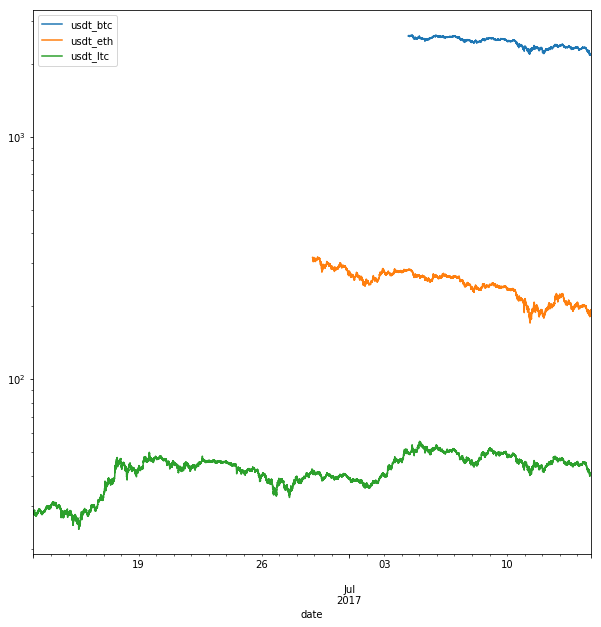

In [43]:
data = concatenate_series(rates)
data.plot(figsize=(10,10), logy=True);

In [44]:
data.dropna().head()

,usdt_btc,usdt_eth,usdt_ltc
date,,,
2017-07-04 08:58:00,2600.002100,283.515339,49.608063
2017-07-04 08:59:00,2599.711308,282.730660,49.733029
2017-07-04 09:00:00,2592.864391,281.943556,49.651575
2017-07-04 09:01:00,2590.837270,281.497042,49.575931
2017-07-04 09:02:00,2590.434017,281.130690,49.520000


In [54]:
# create the strategy
s = bt.Strategy('s1', [bt.algos.RunDaily(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighInvVol(),
                       bt.algos.Rebalance()])


In [55]:
# create a backtest and run it
test = bt.Backtest(s, data.dropna())
res = bt.run(test)


s1
0% [############################# ] 100% | ETA: 00:00:00

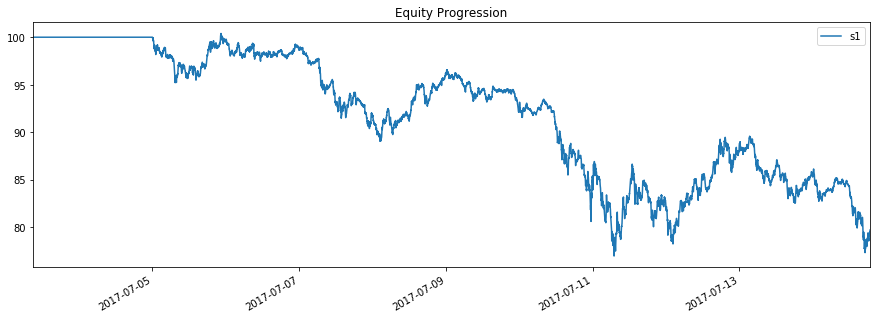

In [56]:
res.plot()


In [57]:
res.display()

Stat                 s1
-------------------  ----------
Start                2017-07-03
End                  2017-07-14
Risk-free rate       0.00%

Total Return         -20.32%
Daily Sharpe         -0.28
Daily Sortino        -0.37
CAGR                 -99.93%
Max Drawdown         -23.36%
Calmar Ratio         -4.28

MTD                  -
3m                   -
6m                   -
YTD                  -20.32%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -99.93%

Daily Sharpe         -0.28
Daily Sortino        -0.37
Daily Mean (ann.)    -0.45%
Daily Vol (ann.)     1.61%
Daily Skew           -0.09
Daily Kurt           5.94
Best Day             0.84%
Worst Day            -0.88%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly Skew         -
Monthly Kurt         -
Best Month           -
Worst Month          -

Yearly Sharpe        -
Yearly Sortino       -
Yearly Mean   

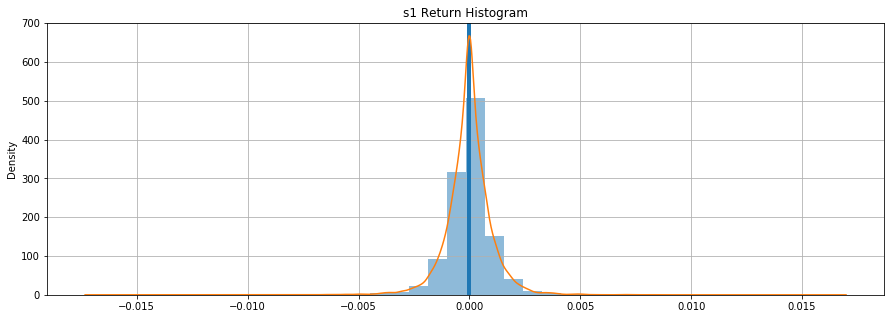

In [58]:
res.plot_histogram(alpha=0.5)
plt.grid()

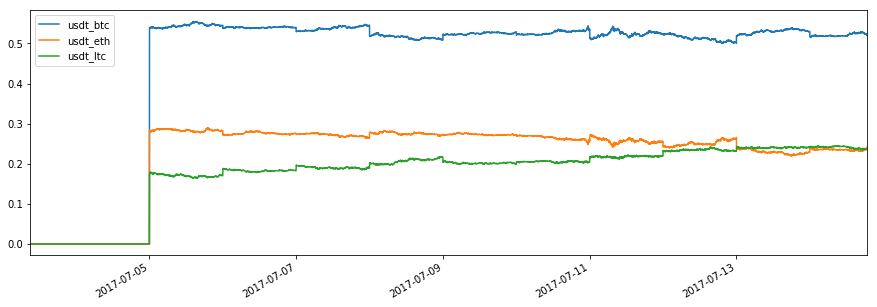

In [59]:
res.plot_security_weights();

In [19]:
df.iloc[-1]

2347.0000000300001